# Poisson-Goodness-of-fit
### Monthly student graduations at a hybrid college
For this project, I hypothesize that monthly student graduations at a competency-based ‘hybrid college’, follow a poisson distribution. 

Unlike traditional universities that provide their students with fixed course and graduation schedules, competency-based programs provide their students with projects that help them build skills and competencies. Students can complete these projects at their own pace. As such, students at hybrid colleges can graduate at any point throughout the year, depending on their individual progress.

My random variable will be the number of students that earn their degree in a given month, such as February 2021, for example. The theoretical distribution I will be using is the Poisson distribution. The data used is sourced from  a competency-based hybrid college and consists of nothing more than anonymized student graduation dates in the format “mm/dd/yyyy” during the years 2016 to 2022.

Let's start with importing the pre-req libraries

In [39]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
from scipy.stats import chi2, chi2_contingency
from IPython.display import display, Math, Latex

Let's define some quick helper functions and variables.

In [40]:
# A global variable to be our main column name
col_name = 'Degree Completion Date'
# Takes a row value and returns the month
def getMonth(row):
    # date = datetime.strptime(row[col_name], '%m/%d/%Y')
    return row[col_name].month

# Takes a row value and returns the year
def getYear(row):
    # date = datetime.strptime(row[col_name], '%m/%d/%Y')
    return row[col_name].year

# Takes a row value and returns the month and year
def getMonthYear(row):
    # date = datetime.strptime(row[col_name], '%m/%d/%Y')
    return str (row[col_name].month)+"-"+str (row[col_name].year)

# Takes a row index and lambda. It returns the poisson probability value 
def getPoissProb(row, l):
    k = row.name
    probability = (pow(l, k)*math.exp(-l))/math.factorial(k)
    return probability

# Takes a row index and total months. It returns expected probability 
def getExpectedProb(row, n):
    return row['Probabilities']*n

# Takes a row index and returns actual frequency minus the expected frquency
def FminNP(row,n):
    return row['Actual Frequencies']-(n*row['Probabilities'])

# Takes a row index and returns actual frequency minus the expected frquency
def FminNPsqrd(row, n):
    return pow(row['Actual Frequencies']-(n*row['Probabilities']), 2)

# Takes a row index and returns actual frequency minus the expected frquency
def x_sqr_approx(row):
    numerator = pow(row['Actual Frequencies']-row['Expected Frequencies'], 2)
    return numerator/row['Expected Frequencies']

Now let's download our spreadsheet data and format it to be helpful.

In [41]:
# Read Excel Sheet
df = pd.read_excel(r'../all_completion_dates.xlsx', sheet_name='Sheet1')
# The length is the total amount of graduations
total_graduations = len(df.index)
# Let's convert all of our dates to datetime objects
df[col_name] = df.apply(lambda row: datetime.strptime(row[col_name], '%m/%d/%Y'), axis=1)

# Filter out our months
df['month'] = df.apply(lambda row: getMonth(row), axis=1)
# Filter out our years
df['year'] = df.apply(lambda row: getYear(row), axis=1)
# Combine our month and year columns to help with frequency distribution
df['month-year']= df.apply(lambda row: getMonthYear(row), axis=1)

# Let's sort our dates in ascending order
df = df.sort_values(by=col_name)
# Let's save our earliest grad
earliestGradDate = df[col_name].iloc[0]
# Let's save our latest grad
latestGradDate = df[col_name].iloc[total_graduations-1]

display(df)


,Degree Completion Date,month,year,month-year
61,2016-06-27,6,2016,6-2016
86,2016-09-10,9,2016,9-2016
23,2016-12-21,12,2016,12-2016
32,2017-02-11,2,2017,2-2017
35,2017-02-18,2,2017,2-2017
...,...,...,...,...
7,2022-10-10,10,2022,10-2022
8,2022-10-19,10,2022,10-2022
10,2022-10-27,10,2022,10-2022
19,2022-11-06,11,2022,11-2022


Let's aggregate our data by the month-year column.

In [42]:
# Let's make a copy of our data frame
agg_df = pd.DataFrame()
# Group the new dataframe by our month-year column values
agg_df = df.groupby(['month-year']).count().reset_index()
# Get rid of the original date data. We won't need it anymore.
agg_df.drop(col_name, inplace=True, axis=1)
# Get rid of the month column. We don't need it.
agg_df.drop('month', inplace=True, axis=1)
# Get rid of the year column. We also don't need it.
agg_df.rename(columns={"year":"count"}, inplace=True)
display(agg_df)

# Suppressing some future deprecation warnings.
print(len(agg_df))
warnings.filterwarnings("ignore")

,month-year,count
0,1-2018,1
1,1-2019,1
2,1-2020,3
3,1-2022,1
4,10-2017,2
5,10-2018,1
6,10-2020,2
7,10-2022,4
8,11-2017,1
9,11-2019,1


52


Our original data doesn't account for months with no grads. How many months are those?

In [43]:
# Get a general datetime object of elapsed dates from the first to last graduation
elapsedDates = relativedelta(latestGradDate, earliestGradDate)
# Turn this general datetime object to months
elapsedMonths = elapsedDates.months+elapsedDates.years*12
# Use elapsed months to find our lambda for the poisson distribution
poissLambda = total_graduations/elapsedMonths
# Get a discrete number on the number of months that had no grads
count_monthsNoGrads = elapsedMonths-len(agg_df)

print("We have",count_monthsNoGrads, "months total with no grads.")
print("Generally we have", poissLambda, "students graduating per month.\n This is the lambda value we will used in our poisson distribution.")

We have 24 months total with no grads.
Generally we have 1.236842105263158 students graduating per month.
 This is the lambda value we will used in our poisson distribution.


Great! Now let's append the months that had no graduates to our month-year aggregated dataframe.

In [44]:
# Let's create a new dataframe
df_agg = pd.DataFrame()
# Copy over our previous dataframe
df_agg = agg_df

# Into our new dataframe let's add our months with no grads
counter = 0
while(counter < count_monthsNoGrads):
    df_agg = df_agg.append({'month-year': '0-0', 'count':0}, ignore_index=True)
    counter = counter+1

display(df_agg)

,month-year,count
0,1-2018,1
1,1-2019,1
2,1-2020,3
3,1-2022,1
4,10-2017,2
...,...,...
71,0-0,0
72,0-0,0
73,0-0,0
74,0-0,0


From here, we can create a frequency distribution dataframe by aggregating our month-year aggregated dataframe by the count column.

In [45]:
# Create a new dataframe and insert our df_agg dataframe grouped by our count column values
frequencies = pd.DataFrame({'Actual Frequencies' : df_agg.groupby(["count"]).size()})
# Let's sort our frequencies dataframe
frequencies = frequencies.sort_values(by=["count", "Actual Frequencies"], ignore_index=True)
display(frequencies)


,Actual Frequencies
0,24
1,26
2,17
3,4
4,4
5,1


We can also display this frequency distribution on a histogram.

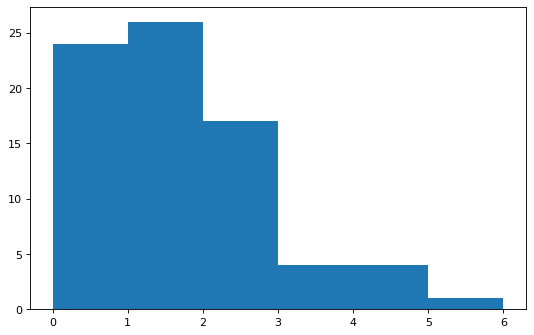

In [46]:
# Show our frequncy in a histogram
plt.figure(figsize=(8,5), dpi=80)
plt.hist(df_agg['count'], bins=[0, 1, 2, 3, 4, 5, 6])
plt.show()

For fun, we can create a poisson pdf diagram with our λ, poissLambda variable, and overlay it above our histogram to see the similarities.
In the diagram we're creating below, the Poisson PDF is illustrated with the red line.

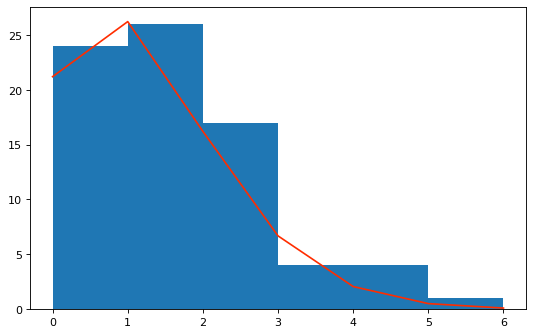

In [51]:
# Make x values for our Poisson PDF
x = np.arange(0, 7, 1)
# Make y values for our Poisson PDF with our custom λ value based on our data.
y = poisson.pmf(x, mu=poissLambda, loc=0)*73
# Recreate our histogram from actual values
plt.figure(figsize=(8,5), dpi=80)
plt.hist(df_agg['count'], bins=[0, 1, 2, 3, 4, 5, 6])
# Plot our Poisson PDF above our histogram
plt.plot( x, y, '#FF2D00' )

plt.show()


We have a general idea of fit with this diagram. Now we can prepare a Chi-Squared goodness of fit test to get a more accurate understanding of fit. 

Let's fill out our frequency distribution dataframe with the following columns:
* poisson probabilities
    - $\lambda$ = the variable poissLambda
* expected frequencies
    - $np_i$
* $\left(f_i-np_i\right)$
* $\left(f_i-np_i\right)^2$
* Chi-square Approximations
    - $\sum_{i=1}^{k}{\frac{\left(f_i-np_i\right)^2}{np_i}}$ ~ $\mathcal{X}_{k-1}^2$

In [48]:
frequencies['Probabilities'] = frequencies.apply(lambda row: getPoissProb(row, poissLambda), axis=1)
frequencies['Expected Frequencies'] = frequencies.apply(lambda row: getExpectedProb(row, elapsedMonths), axis=1)
frequencies['(f-np)'] = frequencies.apply(lambda row: FminNP(row, elapsedMonths), axis=1)
frequencies['(f-np)^2'] = frequencies.apply(lambda row: FminNPsqrd(row, elapsedMonths), axis=1)
frequencies['Chi-square Approximations'] = frequencies.apply(lambda row: x_sqr_approx(row), axis=1)
actual_frequencies_sum = frequencies['Actual Frequencies'].sum()
chi_squared = frequencies['Chi-square Approximations'].sum()

display(frequencies)
print('Σ of Actual Frequencies:', actual_frequencies_sum)
display(Math(r'\mathcal{X}^2=\sum_{i=1}^{k}{\frac{{(f_i-np_i)}^2}{np_i}:}'), chi_squared)

,Actual Frequencies,Probabilities,Expected Frequencies,(f-np),(f-np)^2,Chi-square Approximations
0,24,0.290300,22.062763,1.937237,3.752889,0.170101
1,26,0.359055,27.288154,-1.288154,1.659340,0.060808
2,17,0.222047,16.875569,0.124431,0.015483,0.000917
3,4,0.091546,6.957471,-2.957471,8.746637,1.257157
4,4,0.028307,2.151323,1.848677,3.417605,1.588606
5,1,0.007002,0.532169,0.467831,0.218865,0.411270


Σ of Actual Frequencies: 76


<IPython.core.display.Math object>

3.488859729366961

We can now create a Chi-square PDF with a value, $dof$. This value represents degrees of freedom and we can find it using our number of intervals, $k$, and our number of parameters to estimate from the sample, $r=1$.

In [49]:
k=frequencies['Actual Frequencies'].count()
r = 1
dof = k-1-r

print("We have",dof,"degrees of freedom.")

We have 4 degrees of freedom.


From a [Chi-square distribution table](https://www.medcalc.org/manual/chi-square-table.php), we can see that an $\alpha=0.05$ and a $dof=4$, gives us a chi-square value of $9.488$.

We can now generate our Chi-squared PDF. The green vertical line represents the Chi-squared value we got from our frequency table. If this value falls anywhere within the red shaded region under the curve, then we would reject our hypothesis.

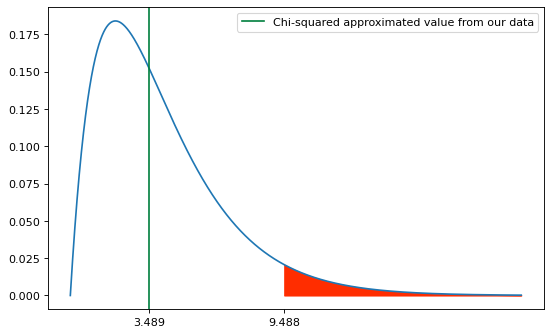

In [52]:
# Define the table-derived chi-square value to set our left-hand limit for the red-shaded region
chi_2val = 9.488
# Define a lower bound of the chi-square pdf
l_b = 0
# Define a upper bound of the chi-square pdf
u_b = 20
# x-axis ranges from l_b to u_b with .001 steps
x = np.arange(l_b, u_b, 0.001)

# Define a function to handle chi-square pdf y-values
def f(t):
    return chi2.pdf(t, df=dof)
#plot Chi-square distribution with 4 degrees of freedom
plt.figure(figsize=(8,5), dpi=80)
plt.plot(x, f(x))
#Fill in the rejected area under the curve with red
plt.fill_between(
        x= x, 
        y1= f(x), 
        where= (chi_2val < x)&(x < 20),
        color= "#FF2D00",
        alpha= 1)
# Draw a vertical line that illustrates the chi-squared approximated value from our data
plt.axvline(x = chi_squared, color = '#007F3E', label = 'Chi-squared approximated value from our data')
# Draw a vertical line that illustrates the table-derrived chi-square value
# plt.axvline(x = chi_2val, color = '#FF2D00', label = 'Table-derived chi-square value')
plt.xticks([chi_squared, chi_2val])
# plt.xlabel("Table-derived chi-square value")

plt.legend()
plt.show()

$H_0:f\left(x\right)=Poisson\left(\lambda=1.236842105263158\right)$

$H_A:f\left(x\right)\neq\ Poisson\left(\lambda=1.236842105263158\right)$

We reject $H_0$ if 
$\mathcal{X}^2>\mathcal{X}^2_{\alpha}=9.488$ 

As shown by our diagram above, our chi-squared approximated value falls well under our chi-square distribution and well below our rejection area. Therefore there is no evidence to reject our null-hypothesis about the Poisson distribution. The number of students that graduate per month at this competency-based hybrid college follows a Poisson distribution.